# Analisis dan Pemodelan Machine Learning Dataset Automobile

Dalam notebook ini, kita akan melakukan:
1. Eksplorasi Data (EDA)
2. Preprocessing dan Handling Missing Values
3. Feature Engineering
4. Pemodelan dengan Teknik Bagging (Random Forest)
5. Pemodelan dengan Teknik Boosting (Gradient Boosting, AdaBoost, XGBoost)
6. Evaluasi Model dengan RMSE, MSE, dan R-Squared

In [110]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from math import sqrt

# Set style untuk visualisasi
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Supaya output tidak terpotong
pd.set_option('display.max_columns', None)

## Fungsi Pengambilan Nama Feature

In [111]:
def get_feature_names(X, categorical_features, numeric_features, preprocessor):
    """
    Mendapatkan nama fitur setelah preprocessing (termasuk hasil one-hot encoding)
    """
    # Feature names untuk numerik tetap sama
    feature_names = numeric_features.copy()

    # Untuk kategorikal, dapatkan semua kategori unik
    for cat_feature in categorical_features:
        categories = X[cat_feature].unique()
        for category in categories:
            feature_names.append(f"{cat_feature}_{category}")

    return feature_names

## Fungsi Visualisasi Model

In [112]:
def visualize_regression_model(model_name, model_results, X_test, y_test, feature_names=None):
    """
    Visualisasi komprehensif untuk model regresi

    Parameters:
    -----------
    model_name : str
        Nama model untuk judul visualisasi
    model_results : dict
        Dictionary berisi hasil evaluasi model dan model itu sendiri
    X_test : array-like
        Data fitur testing
    y_test : array-like
        Data target testing
    feature_names : list, optional
        Nama-nama fitur untuk plot feature importance
    """
    model = model_results['model']
    y_test_pred = model_results['y_test_pred']

    # 1. Buat figure dengan 2x2 subplot
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle(f'Visualisasi Model {model_name}', fontsize=20)

    # 2. Scatter plot Prediksi vs Aktual
    axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6)
    axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[0, 0].set_xlabel('Nilai Aktual')
    axes[0, 0].set_ylabel('Nilai Prediksi')
    axes[0, 0].set_title('Prediksi vs Aktual')
    axes[0, 0].grid(True)

    # Tambahkan R² ke plot
    r2 = model_results['test_r2']
    axes[0, 0].text(0.05, 0.95, f'R² = {r2:.4f}', transform=axes[0, 0].transAxes,
                 fontsize=12, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 3. Plot Residual
    residuals = y_test - y_test_pred
    axes[0, 1].scatter(y_test_pred, residuals, alpha=0.6)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Nilai Prediksi')
    axes[0, 1].set_ylabel('Residual (Aktual - Prediksi)')
    axes[0, 1].set_title('Plot Residual')
    axes[0, 1].grid(True)

    # 4. Histogram Residual
    axes[1, 0].hist(residuals, bins=30, alpha=0.6, color='skyblue', edgecolor='black')
    axes[1, 0].axvline(x=0, color='r', linestyle='--')
    axes[1, 0].set_xlabel('Residual')
    axes[1, 0].set_ylabel('Frekuensi')
    axes[1, 0].set_title('Distribusi Residual')
    axes[1, 0].grid(True)

    # 5. Feature Importance (jika model mendukung)
    if hasattr(model, 'feature_importances_') and feature_names is not None:
        # Ambil top 15 feature importance
        n_features = min(15, len(feature_names))
        importances = model.feature_importances_
        indices = np.argsort(importances)[-n_features:]

        axes[1, 1].barh(range(n_features), importances[indices])
        axes[1, 1].set_yticks(range(n_features))
        axes[1, 1].set_yticklabels([feature_names[i] for i in indices])
        axes[1, 1].set_xlabel('Feature Importance')
        axes[1, 1].set_title('Top 15 Feature Importance')
    else:
        axes[1, 1].text(0.5, 0.5, 'Feature Importance tidak tersedia untuk model ini',
                     ha='center', va='center', transform=axes[1, 1].transAxes)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Memberi ruang untuk judul utama
    plt.show()

    # Tambahan: box plot perbandingan aktual vs prediksi
    plt.figure(figsize=(10, 6))
    data_to_plot = [y_test, y_test_pred]
    labels = ['Nilai Aktual', 'Nilai Prediksi']

    plt.boxplot(data_to_plot, labels=labels)
    plt.title(f'Boxplot Perbandingan Aktual vs Prediksi - {model_name}')
    plt.grid(True, axis='y')
    plt.show()

    # Tambahan: scatter plot dengan regresi line untuk visualisasi yang lebih baik
    plt.figure(figsize=(10, 6))
    sns.regplot(x=y_test, y=y_test_pred, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
    plt.xlabel('Nilai Aktual')
    plt.ylabel('Nilai Prediksi')
    plt.title(f'Scatter Plot dengan Regresi Line - {model_name}')
    plt.grid(True)

    # Tambahkan informasi metrik evaluasi
    rmse = model_results['test_rmse']
    plt.text(0.05, 0.95, f'R² = {r2:.4f}\nRMSE = {rmse:.2f}', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.tight_layout()
    plt.show()

## 1. Membaca dan Mengeksplorasi Data

In [113]:
# Membaca data
automobile_df = pd.read_csv('Automobile.csv')

# Melihat 5 data pertama
print("Dimensi dataset:", automobile_df.shape)
automobile_df.head()

Dimensi dataset: (205, 26)


,price,highway-mpg,city-mpg,peak-rpm,horsepower,compression-ratio,stroke,bore,fuel-system,engine-size,num-of-cylinders,engine-type,curb-weight,height,width,length,wheel-base,engine-location,drive-wheels,body-style,num-of-doors,aspiration,fuel-type,make,normalized-losses,symboling
0,13495.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,4,dohc,2548,48.8,64.1,168.8,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN,3
1,16500.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,4,dohc,2548,48.8,64.1,168.8,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN,3
2,16500.0,26,19,5000.0,154.0,9.0,3.47,2.68,mpfi,152,6,ohcv,2823,52.4,65.5,171.2,94.5,front,rwd,hatchback,2.0,std,gas,alfa-romero,NaN,1
3,13950.0,30,24,5500.0,102.0,10.0,3.40,3.19,mpfi,109,4,ohc,2337,54.3,66.2,176.6,99.8,front,fwd,sedan,4.0,std,gas,audi,164.0,2
4,17450.0,22,18,5500.0,115.0,8.0,3.40,3.19,mpfi,136,5,ohc,2824,54.3,66.4,176.6,99.4,front,4wd,sedan,4.0,std,gas,audi,164.0,2


In [114]:
# Informasi data
automobile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              201 non-null    float64
 1   highway-mpg        205 non-null    int64  
 2   city-mpg           205 non-null    int64  
 3   peak-rpm           203 non-null    float64
 4   horsepower         203 non-null    float64
 5   compression-ratio  205 non-null    float64
 6   stroke             201 non-null    float64
 7   bore               201 non-null    float64
 8   fuel-system        205 non-null    object 
 9   engine-size        205 non-null    int64  
 10  num-of-cylinders   205 non-null    int64  
 11  engine-type        205 non-null    object 
 12  curb-weight        205 non-null    int64  
 13  height             205 non-null    float64
 14  width              205 non-null    float64
 15  length             205 non-null    float64
 16  wheel-base         205 non

In [115]:
# Statistik deskriptif
automobile_df.describe()

,price,highway-mpg,city-mpg,peak-rpm,horsepower,compression-ratio,stroke,bore,engine-size,num-of-cylinders,curb-weight,height,width,length,wheel-base,num-of-doors,normalized-losses,symboling
count,201.000000,205.000000,205.000000,203.000000,203.000000,205.000000,201.000000,201.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,203.000000,164.000000,205.000000
mean,13207.129353,30.751220,25.219512,5125.369458,104.256158,10.142537,3.255423,3.329751,126.907317,4.380488,2555.565854,53.724878,65.907805,174.049268,98.756585,3.123153,122.000000,0.834146
std,7947.066342,6.886443,6.542142,479.334560,39.714369,3.972040,0.316717,0.273539,41.642693,1.080854,520.680204,2.443522,2.145204,12.337289,6.021776,0.994841,35.442168,1.245307
min,5118.000000,16.000000,13.000000,4150.000000,48.000000,7.000000,2.070000,2.540000,61.000000,2.000000,1488.000000,47.800000,60.300000,141.100000,86.600000,2.000000,65.000000,-2.000000
25%,7775.000000,25.000000,19.000000,4800.000000,70.000000,8.600000,3.110000,3.150000,97.000000,4.000000,2145.000000,52.000000,64.100000,166.300000,94.500000,2.000000,94.000000,0.000000
50%,10295.000000,30.000000,24.000000,5200.000000,95.000000,9.000000,3.290000,3.310000,120.000000,4.000000,2414.000000,54.100000,65.500000,173.200000,97.000000,4.000000,115.000000,1.000000
75%,16500.000000,34.000000,30.000000,5500.000000,116.000000,9.400000,3.410000,3.590000,141.000000,4.000000,2935.000000,55.500000,66.900000,183.100000,102.400000,4.000000,150.000000,2.000000
max,45400.000000,54.000000,49.000000,6600.000000,288.000000,23.000000,4.170000,3.940000,326.000000,12.000000,4066.000000,59.800000,72.300000,208.100000,120.900000,4.000000,256.000000,3.000000


In [116]:
# Memeriksa missing values
missing_values = automobile_df.isnull().sum()
missing_percentage = (missing_values / len(automobile_df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print("Missing Values:")
missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False)

Missing Values:


,Missing Values,Percentage
normalized-losses,41,20.00000
stroke,4,1.95122
price,4,1.95122
bore,4,1.95122
peak-rpm,2,0.97561
horsepower,2,0.97561
num-of-doors,2,0.97561


## 2. Exploratory Data Analysis (EDA)

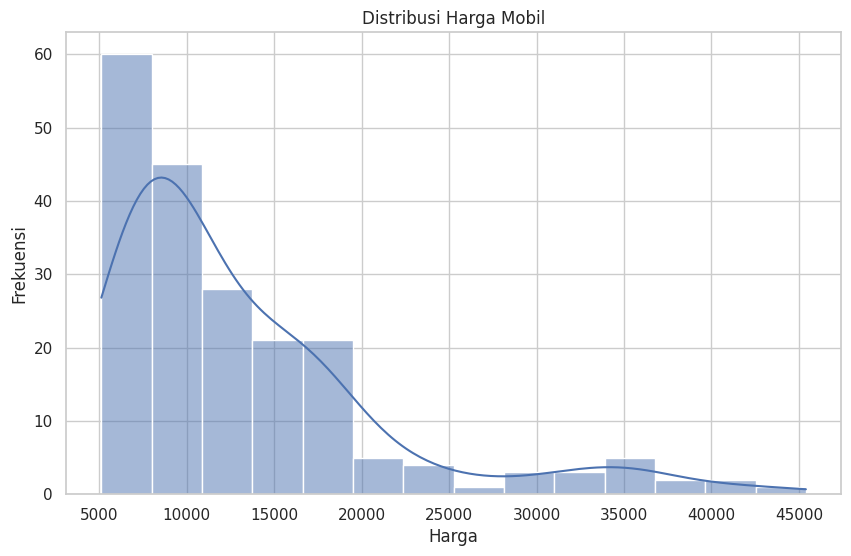

Skewness harga: 1.8096753390980749


In [117]:
# Memeriksa distribusi target (price)
plt.figure(figsize=(10, 6))
sns.histplot(automobile_df['price'], kde=True)
plt.title('Distribusi Harga Mobil')
plt.xlabel('Harga')
plt.ylabel('Frekuensi')
plt.show()

# Memeriksa skewness
print(f"Skewness harga: {automobile_df['price'].skew()}")

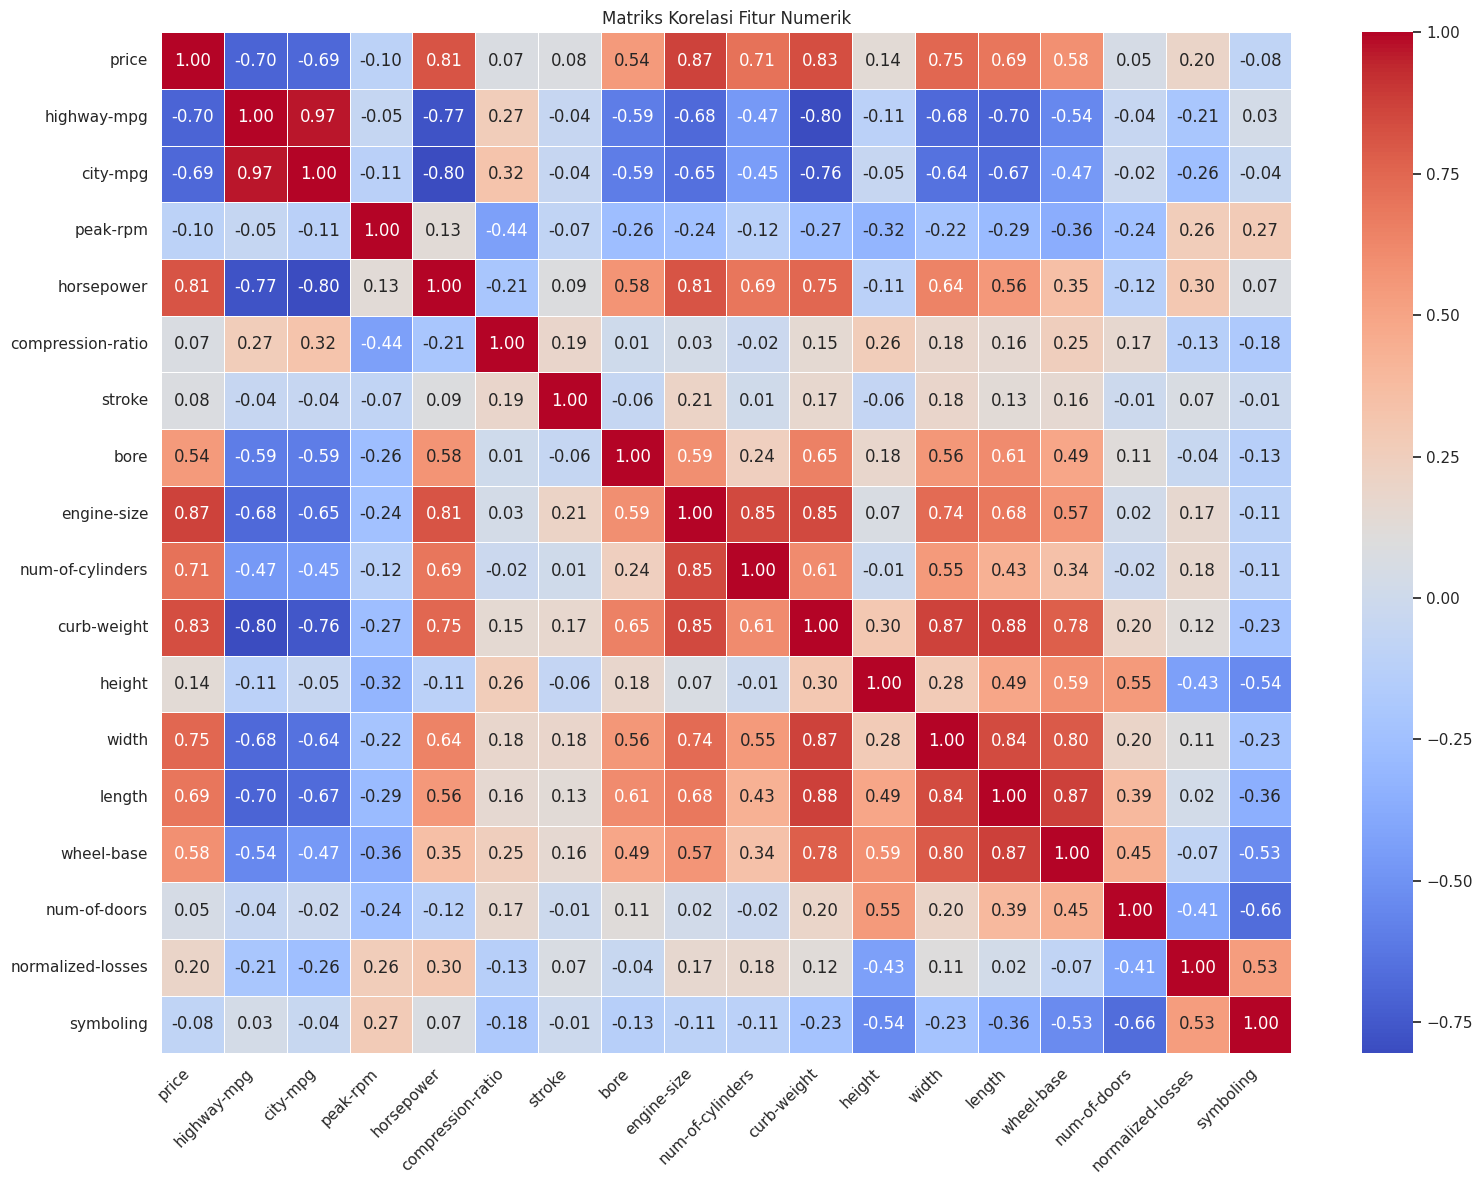

In [118]:
# Melihat korelasi antara fitur numerik
numeric_features = automobile_df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = automobile_df[numeric_features].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriks Korelasi Fitur Numerik')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

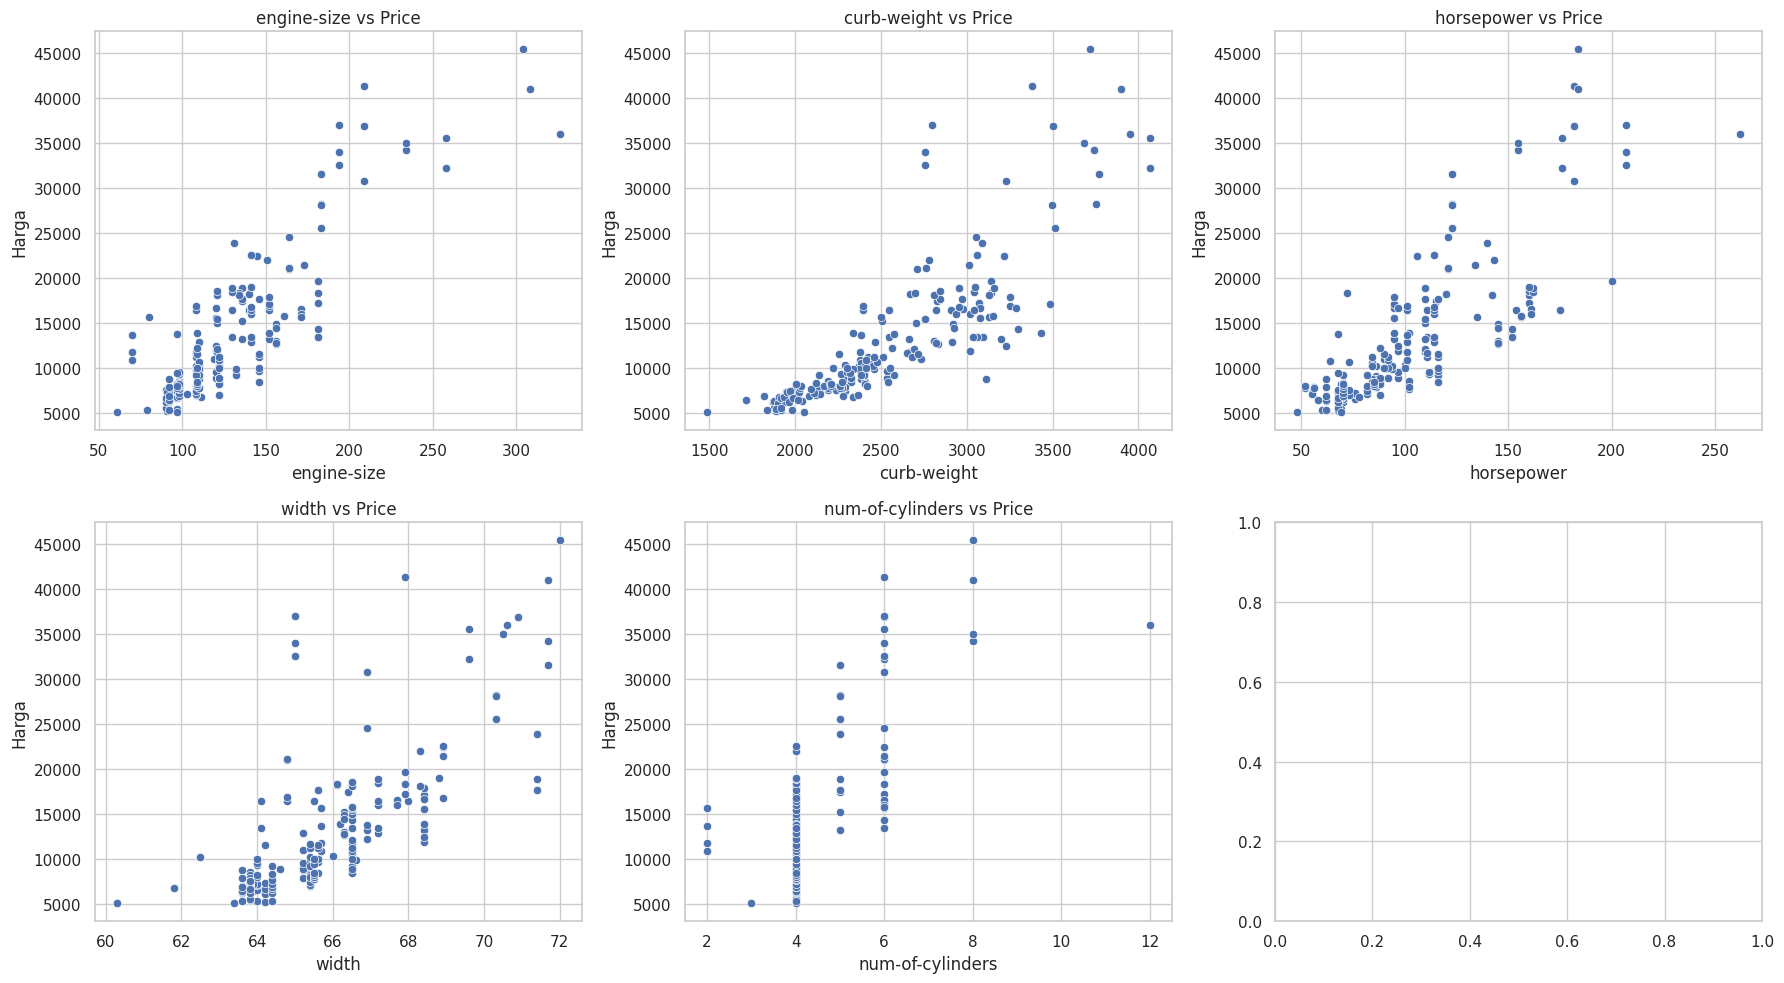

In [119]:
# Melihat hubungan antara fitur numerik top dengan harga
top_corr_features = correlation_matrix['price'].abs().sort_values(ascending=False)[1:6].index

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(top_corr_features):
    sns.scatterplot(x=automobile_df[feature], y=automobile_df['price'], ax=axes[i])
    axes[i].set_title(f'{feature} vs Price')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Harga')

plt.tight_layout()
plt.show()

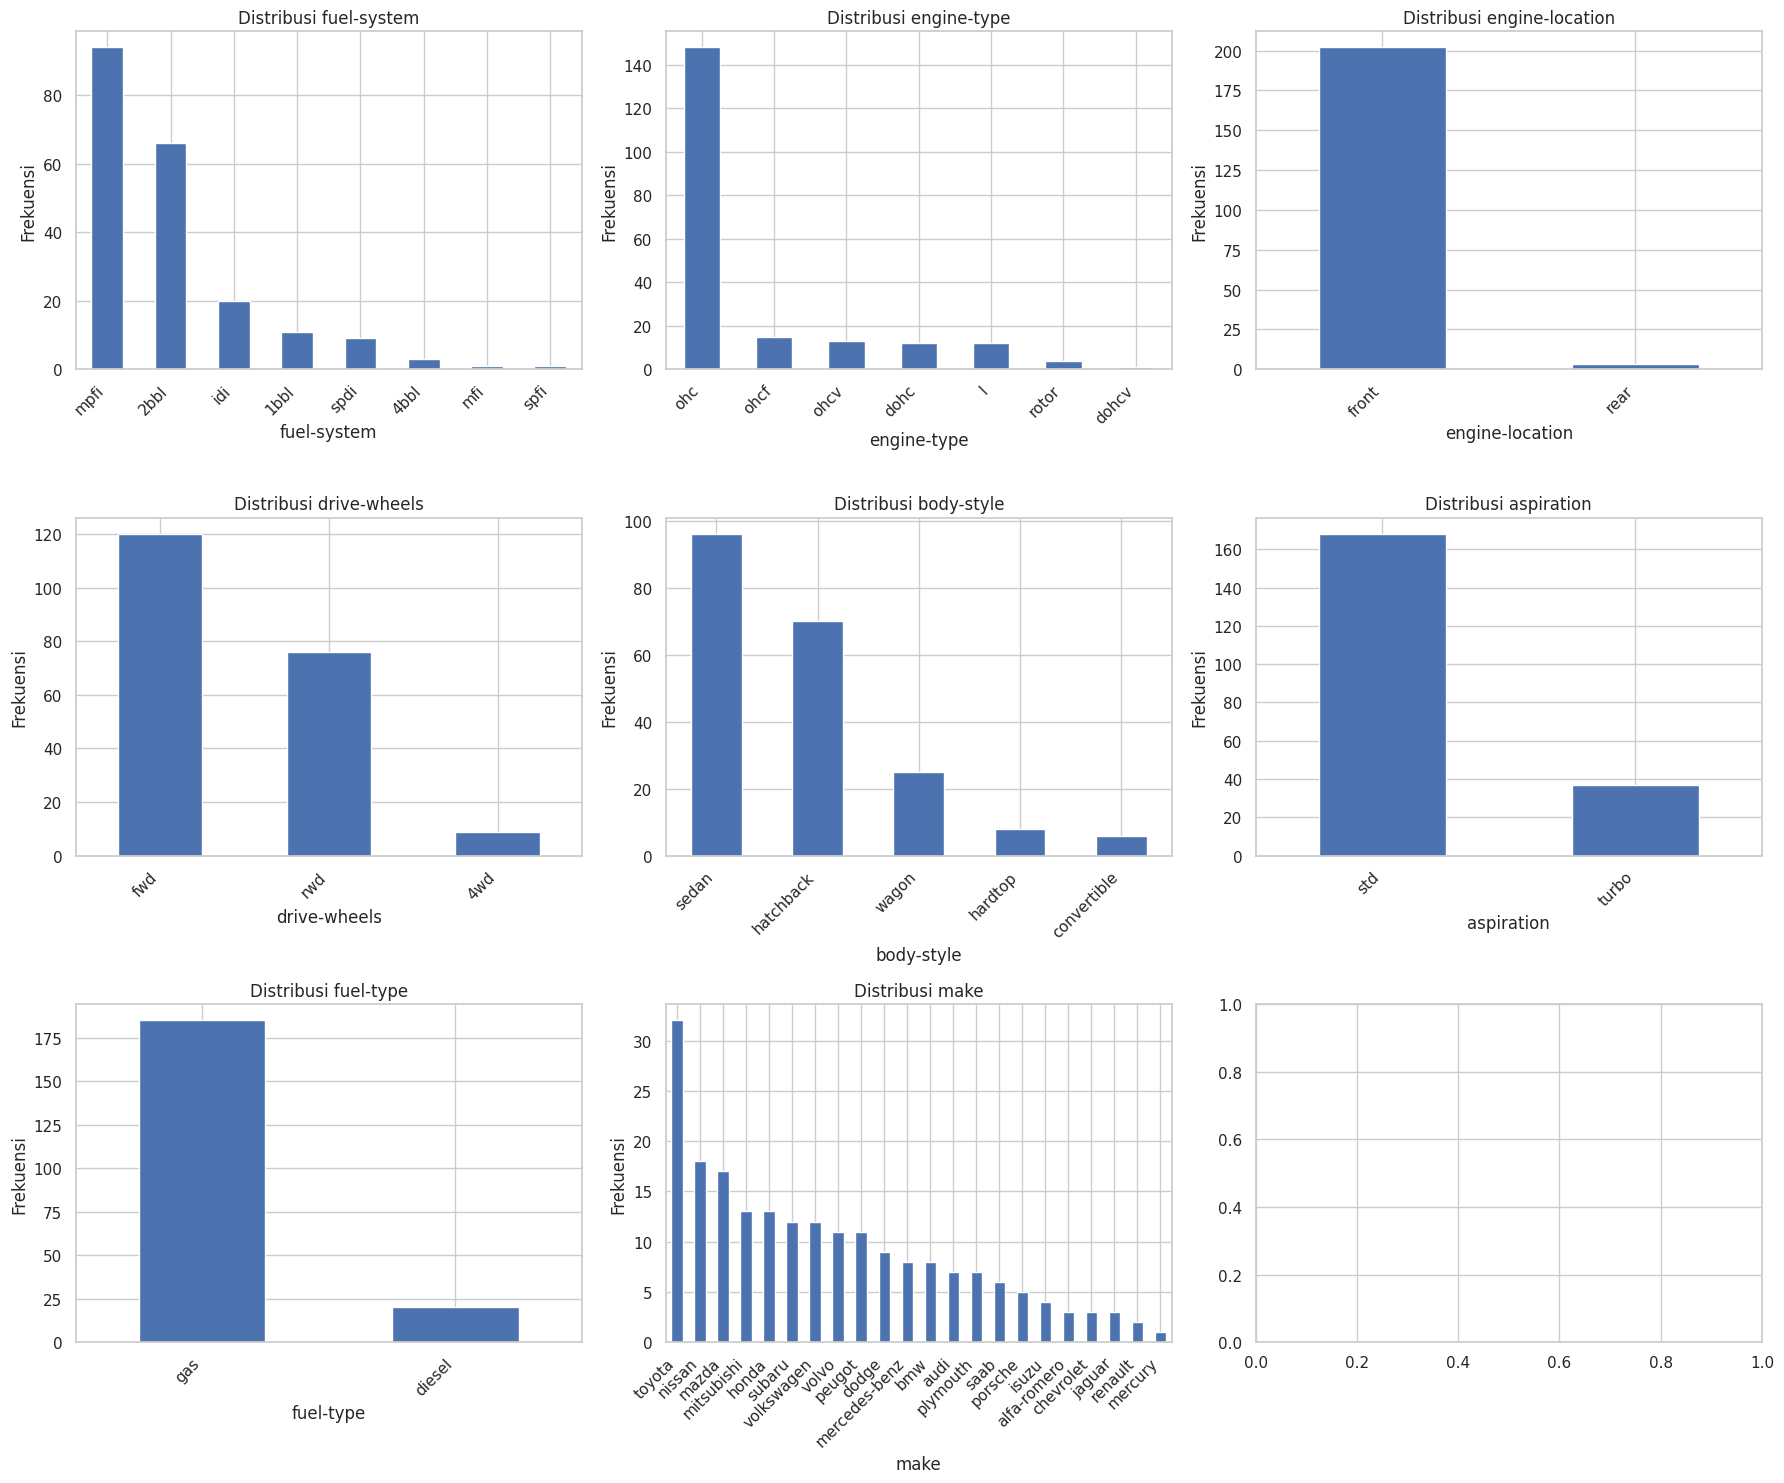

In [120]:
# Melihat distribusi fitur kategorikal
categorical_features = automobile_df.select_dtypes(include=['object']).columns

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, feature in enumerate(categorical_features[:min(9, len(categorical_features))]):
    automobile_df[feature].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Distribusi {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frekuensi')
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

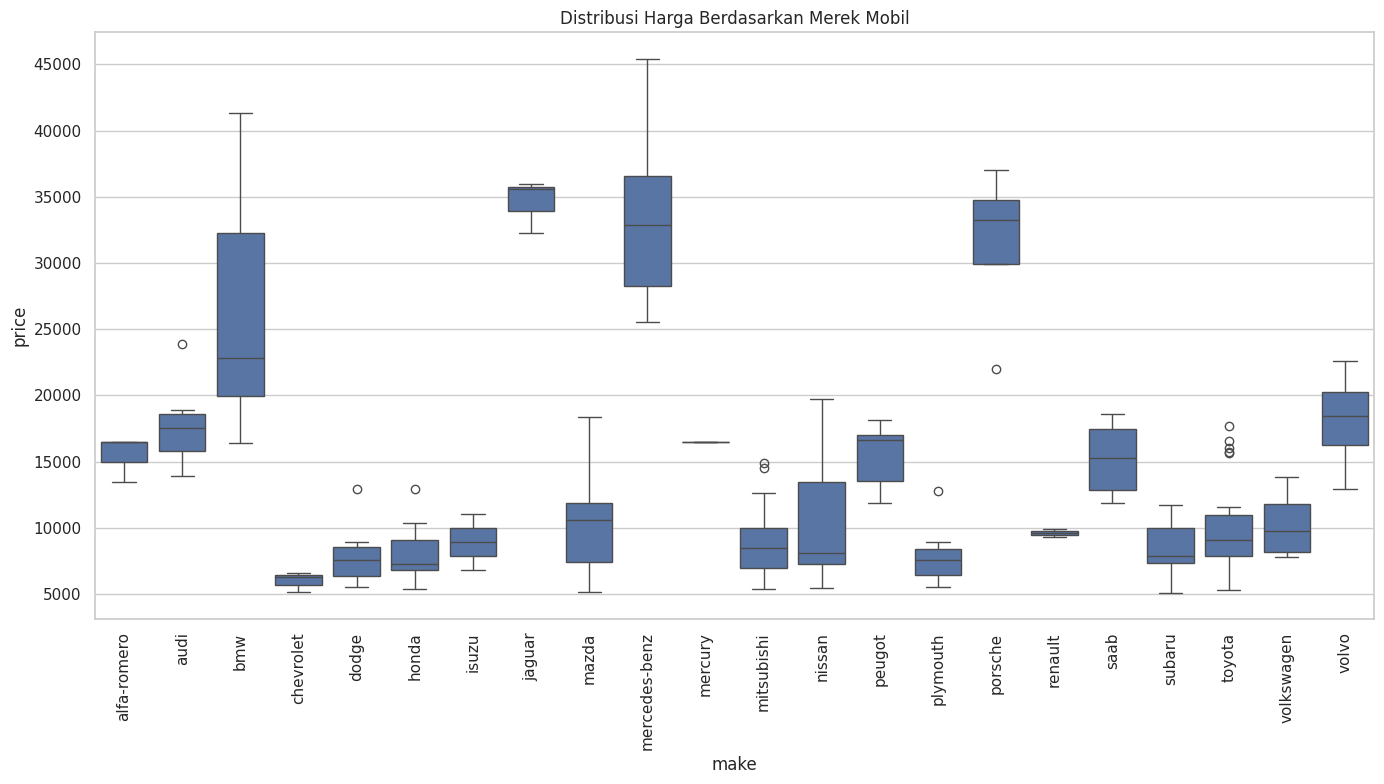

In [121]:
# Boxplot harga berdasarkan make
plt.figure(figsize=(14, 8))
sns.boxplot(x='make', y='price', data=automobile_df)
plt.title('Distribusi Harga Berdasarkan Merek Mobil')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 3. Preprocessing Data dan Handling Missing Values

In [122]:
# Menangani missing values
# Mengubah '?' menjadi NaN jika ada
automobile_df = automobile_df.replace('?', np.nan)

# Konversi tipe data kolom numerik
numeric_cols = ['price', 'highway-mpg', 'city-mpg', 'peak-rpm', 'horsepower',
               'compression-ratio', 'stroke', 'bore', 'engine-size', 'curb-weight',
               'height', 'width', 'length', 'wheel-base', 'normalized-losses']

for col in numeric_cols:
    if col in automobile_df.columns:
        automobile_df[col] = pd.to_numeric(automobile_df[col], errors='coerce')

# TAMBAHKAN INI: Hapus baris dengan NaN di kolom price (target)
print(f"Jumlah baris sebelum menghapus NaN dari target: {len(automobile_df)}")
automobile_df = automobile_df.dropna(subset=['price'])
print(f"Jumlah baris setelah menghapus NaN dari target: {len(automobile_df)}")

# Memeriksa kembali missing values setelah konversi
missing_values = automobile_df.isnull().sum()
missing_percentage = (missing_values / len(automobile_df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print("Missing Values setelah konversi:")
print(missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False))

Jumlah baris sebelum menghapus NaN dari target: 205
Jumlah baris setelah menghapus NaN dari target: 201
Missing Values setelah konversi:
                   Missing Values  Percentage
normalized-losses              37   18.407960
stroke                          4    1.990050
bore                            4    1.990050
peak-rpm                        2    0.995025
horsepower                      2    0.995025
num-of-doors                    2    0.995025


In [123]:
# Memisahkan fitur dan target
X = automobile_df.drop('price', axis=1)  # Semua kolom kecuali 'price'
y = automobile_df['price']               # Kolom 'price' sebagai target

# Identifikasi fitur kategorikal dan numerik
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Fitur kategorikal:", categorical_features)
print("Fitur numerik:", numeric_features)

Fitur kategorikal: ['fuel-system', 'engine-type', 'engine-location', 'drive-wheels', 'body-style', 'aspiration', 'fuel-type', 'make']
Fitur numerik: ['highway-mpg', 'city-mpg', 'peak-rpm', 'horsepower', 'compression-ratio', 'stroke', 'bore', 'engine-size', 'num-of-cylinders', 'curb-weight', 'height', 'width', 'length', 'wheel-base', 'num-of-doors', 'normalized-losses', 'symboling']


## 4. Feature Engineering

In [124]:
# Feature Engineering

# 1. Rasio horsepower terhadap weight
X['power_weight_ratio'] = X['horsepower'] / X['curb-weight']

# 2. Rasio ukuran engine terhadap weight
X['engine_weight_ratio'] = X['engine-size'] / X['curb-weight']

# 3. Rasio dimensi (L/W/H)
X['dimension_ratio'] = X['length'] * X['width'] * X['height']

# 4. Efisiensi bahan bakar (rata-rata MPG)
X['avg_mpg'] = (X['city-mpg'] + X['highway-mpg']) / 2

# 5. Displacement berdasarkan bore, stroke, dan jumlah silinder
X['num-of-cylinders'] = X['num-of-cylinders'].replace({'four': 4, 'six': 6, 'five': 5, 'eight': 8, 'two': 2, 'three': 3, 'twelve': 12})
X['displacement'] = np.pi * (X['bore']/2)**2 * X['stroke'] * X['num-of-cylinders']

# Update fitur numerik setelah feature engineering
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Fitur numerik setelah feature engineering:", numeric_features)

Fitur numerik setelah feature engineering: ['highway-mpg', 'city-mpg', 'peak-rpm', 'horsepower', 'compression-ratio', 'stroke', 'bore', 'engine-size', 'num-of-cylinders', 'curb-weight', 'height', 'width', 'length', 'wheel-base', 'num-of-doors', 'normalized-losses', 'symboling', 'power_weight_ratio', 'engine_weight_ratio', 'dimension_ratio', 'avg_mpg', 'displacement']


In [125]:
# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Jumlah sampel training: {X_train.shape[0]}")
print(f"Jumlah sampel testing: {X_test.shape[0]}")

Jumlah sampel training: 160
Jumlah sampel testing: 41


In [126]:
# Preprocessing Pipeline
# Pipeline untuk fitur numerik
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline untuk fitur kategorikal
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Kombinasi transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit preprocessor pada data training
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print(f"Dimensi X_train setelah preprocessing: {X_train_preprocessed.shape}")
print(f"Dimensi X_test setelah preprocessing: {X_test_preprocessed.shape}")

Dimensi X_train setelah preprocessing: (160, 72)
Dimensi X_test setelah preprocessing: (41, 72)


## 5. Pemodelan dengan Teknik Bagging (Random Forest)

In [127]:
# Fungsi untuk evaluasi model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Fit model
    model.fit(X_train, y_train)

    # Prediksi
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluasi metrik
    # MSE (Mean Squared Error)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # RMSE (Root Mean Squared Error)
    train_rmse = sqrt(train_mse)
    test_rmse = sqrt(test_mse)

    # R^2 (Coefficient of Determination)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"Training MSE: {train_mse:.2f}")
    print(f"Testing MSE: {test_mse:.2f}")
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Testing RMSE: {test_rmse:.2f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")

    return {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'model': model,
        'y_test_pred': y_test_pred
    }

=== Model Random Forest (Bagging) ===
Training MSE: 798782.73
Testing MSE: 8588827.62
Training RMSE: 893.75
Testing RMSE: 2930.67
Training R²: 0.9825
Testing R²: 0.9298
=== Visualisasi Model Random Forest ===


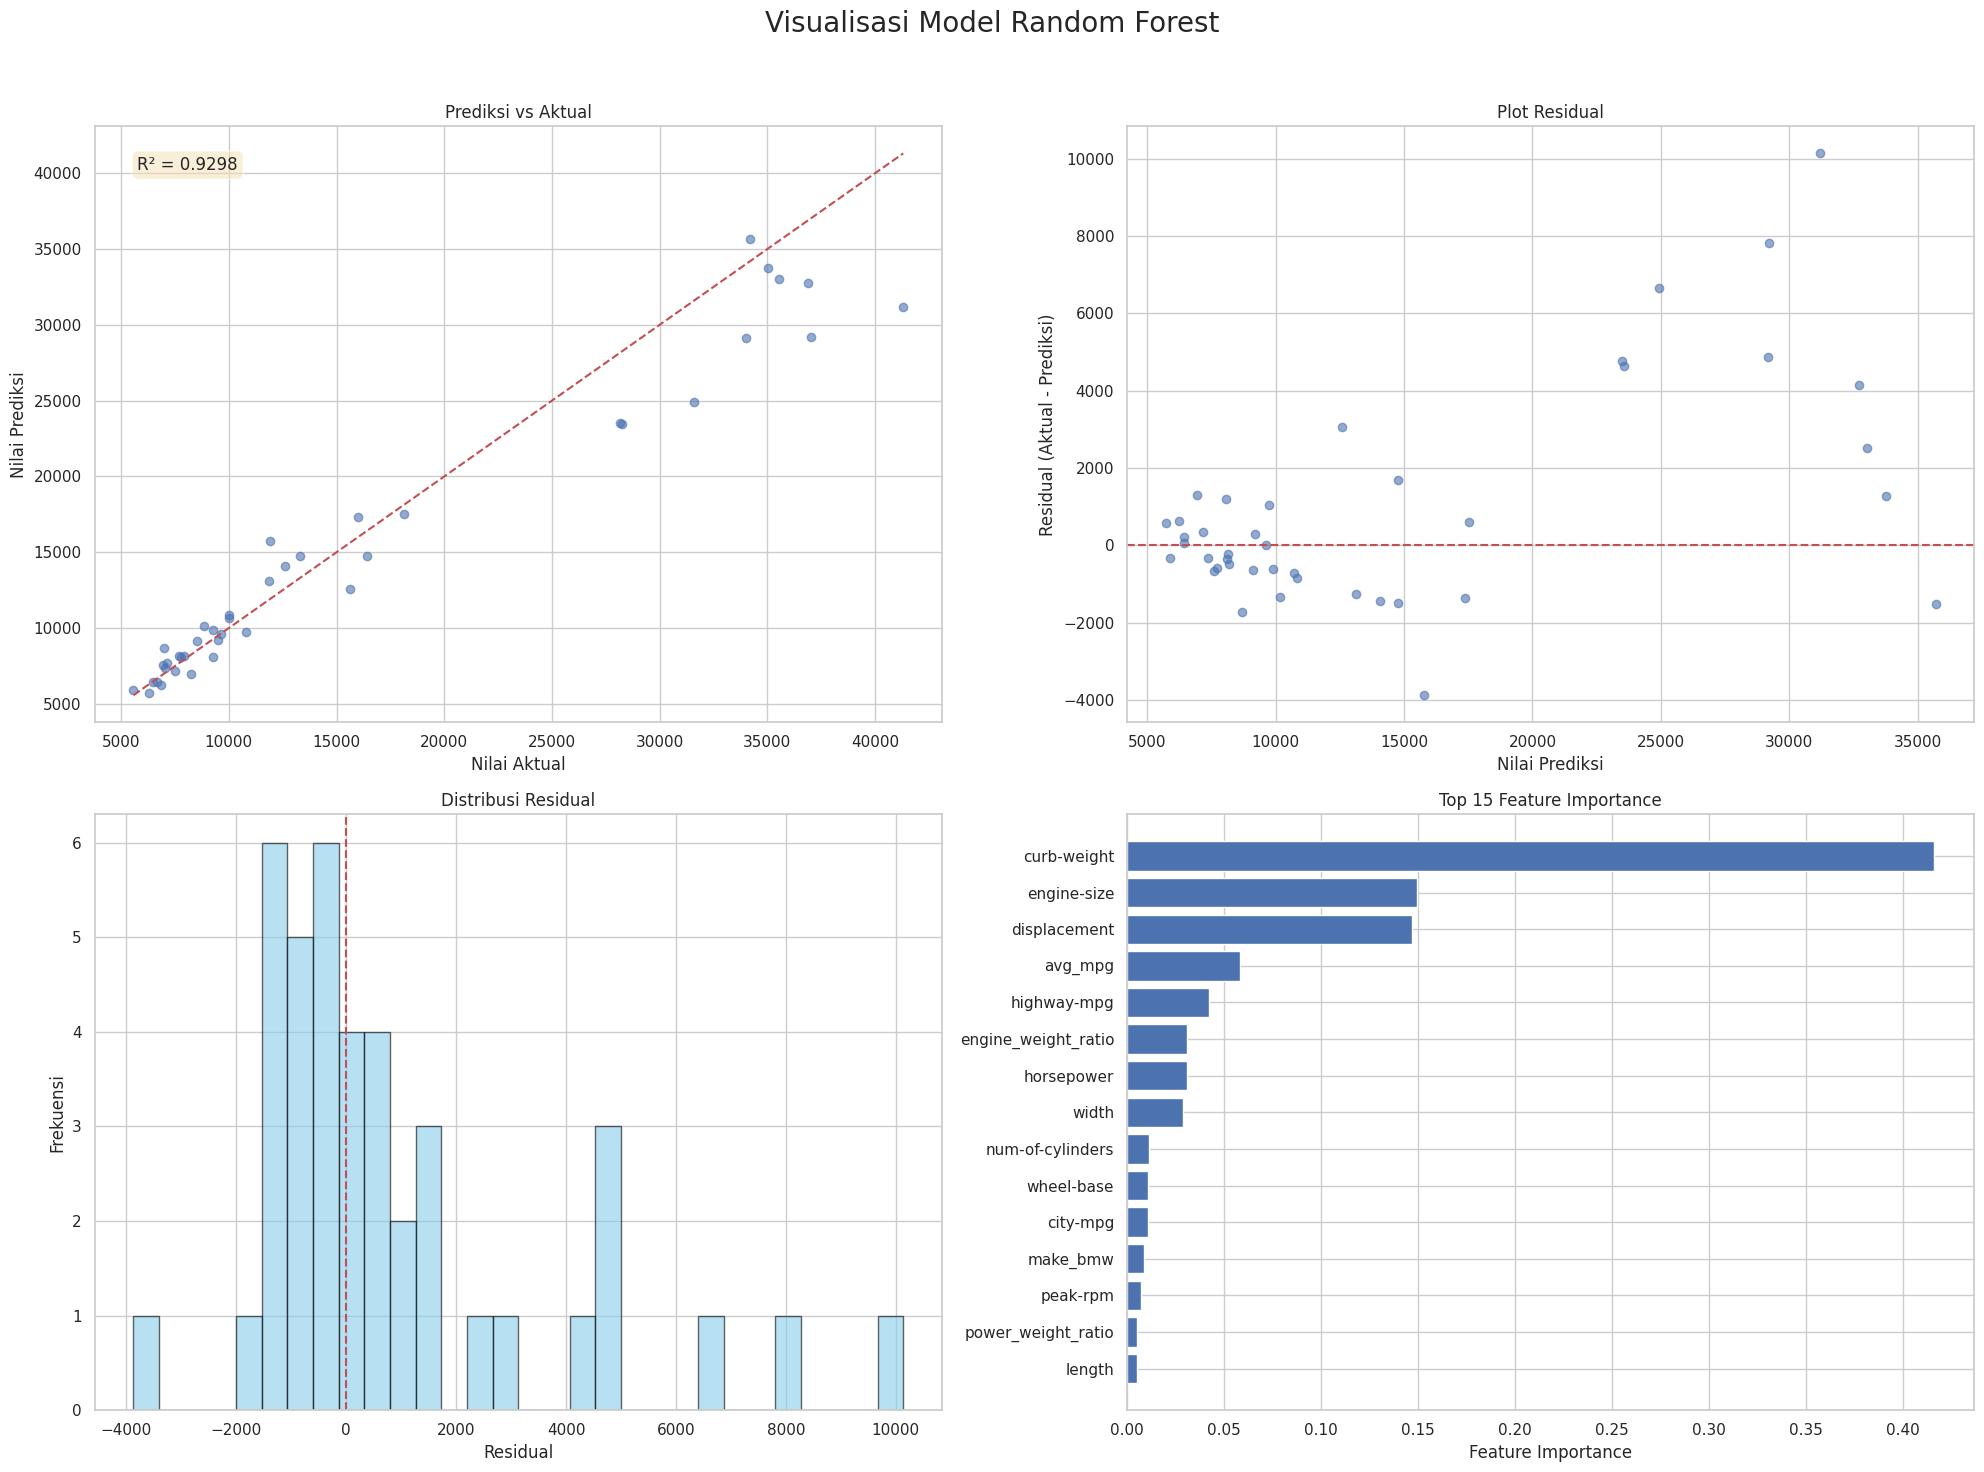

<ipython-input-112-ead1e6fc93b0>:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels)


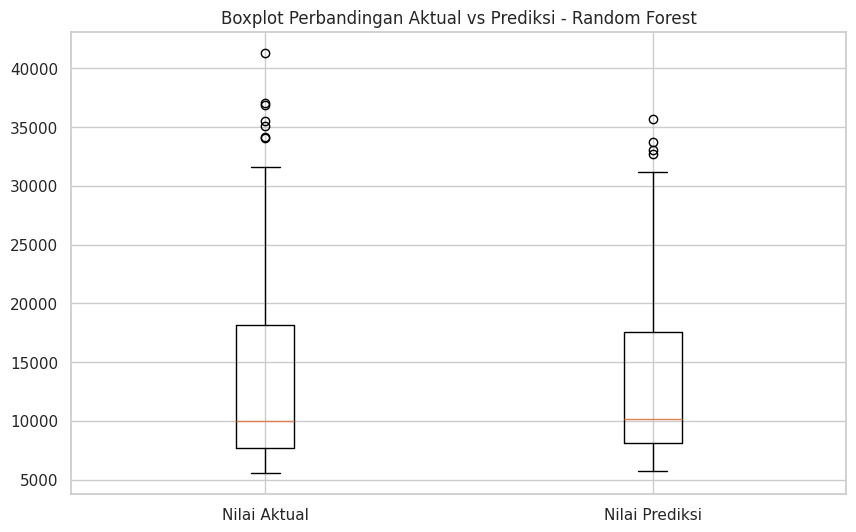

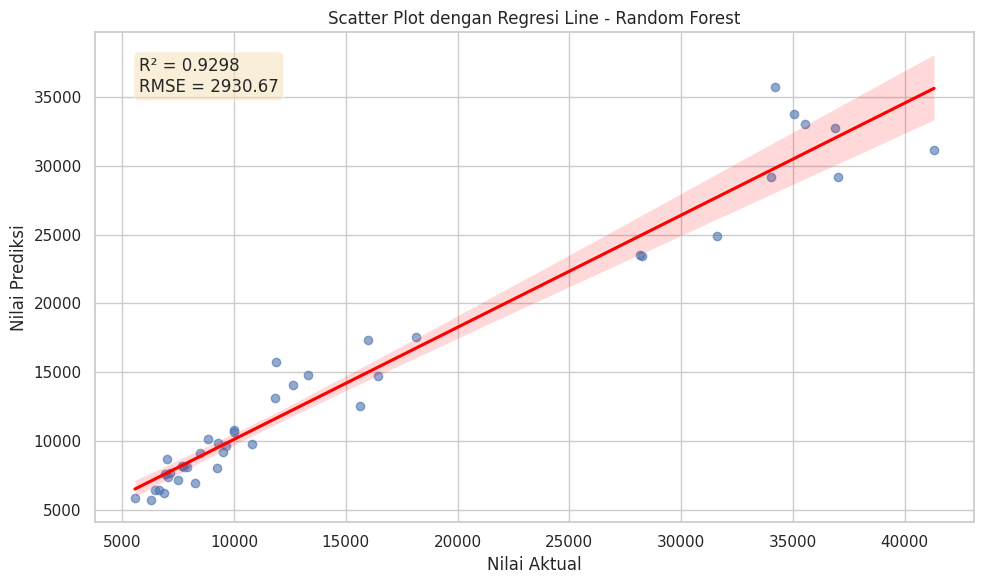

In [128]:
# Model Random Forest (Bagging)
print("=== Model Random Forest (Bagging) ===")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42)
rf_results = evaluate_model(rf_model, X_train_preprocessed, X_test_preprocessed, y_train, y_test)
# Setelah kode pelatihan dan evaluasi Random Forest
print("=== Visualisasi Model Random Forest ===")
feature_names = get_feature_names(X, categorical_features, numeric_features, preprocessor)
visualize_regression_model("Random Forest", rf_results, X_test_preprocessed, y_test, feature_names)

## 6. Pemodelan dengan Teknik Boosting


=== Model Gradient Boosting Regressor ===
Training MSE: 281588.38
Testing MSE: 9612999.46
Training RMSE: 530.65
Testing RMSE: 3100.48
Training R²: 0.9938
Testing R²: 0.9214
=== Visualisasi Model Gradient Boosting ===


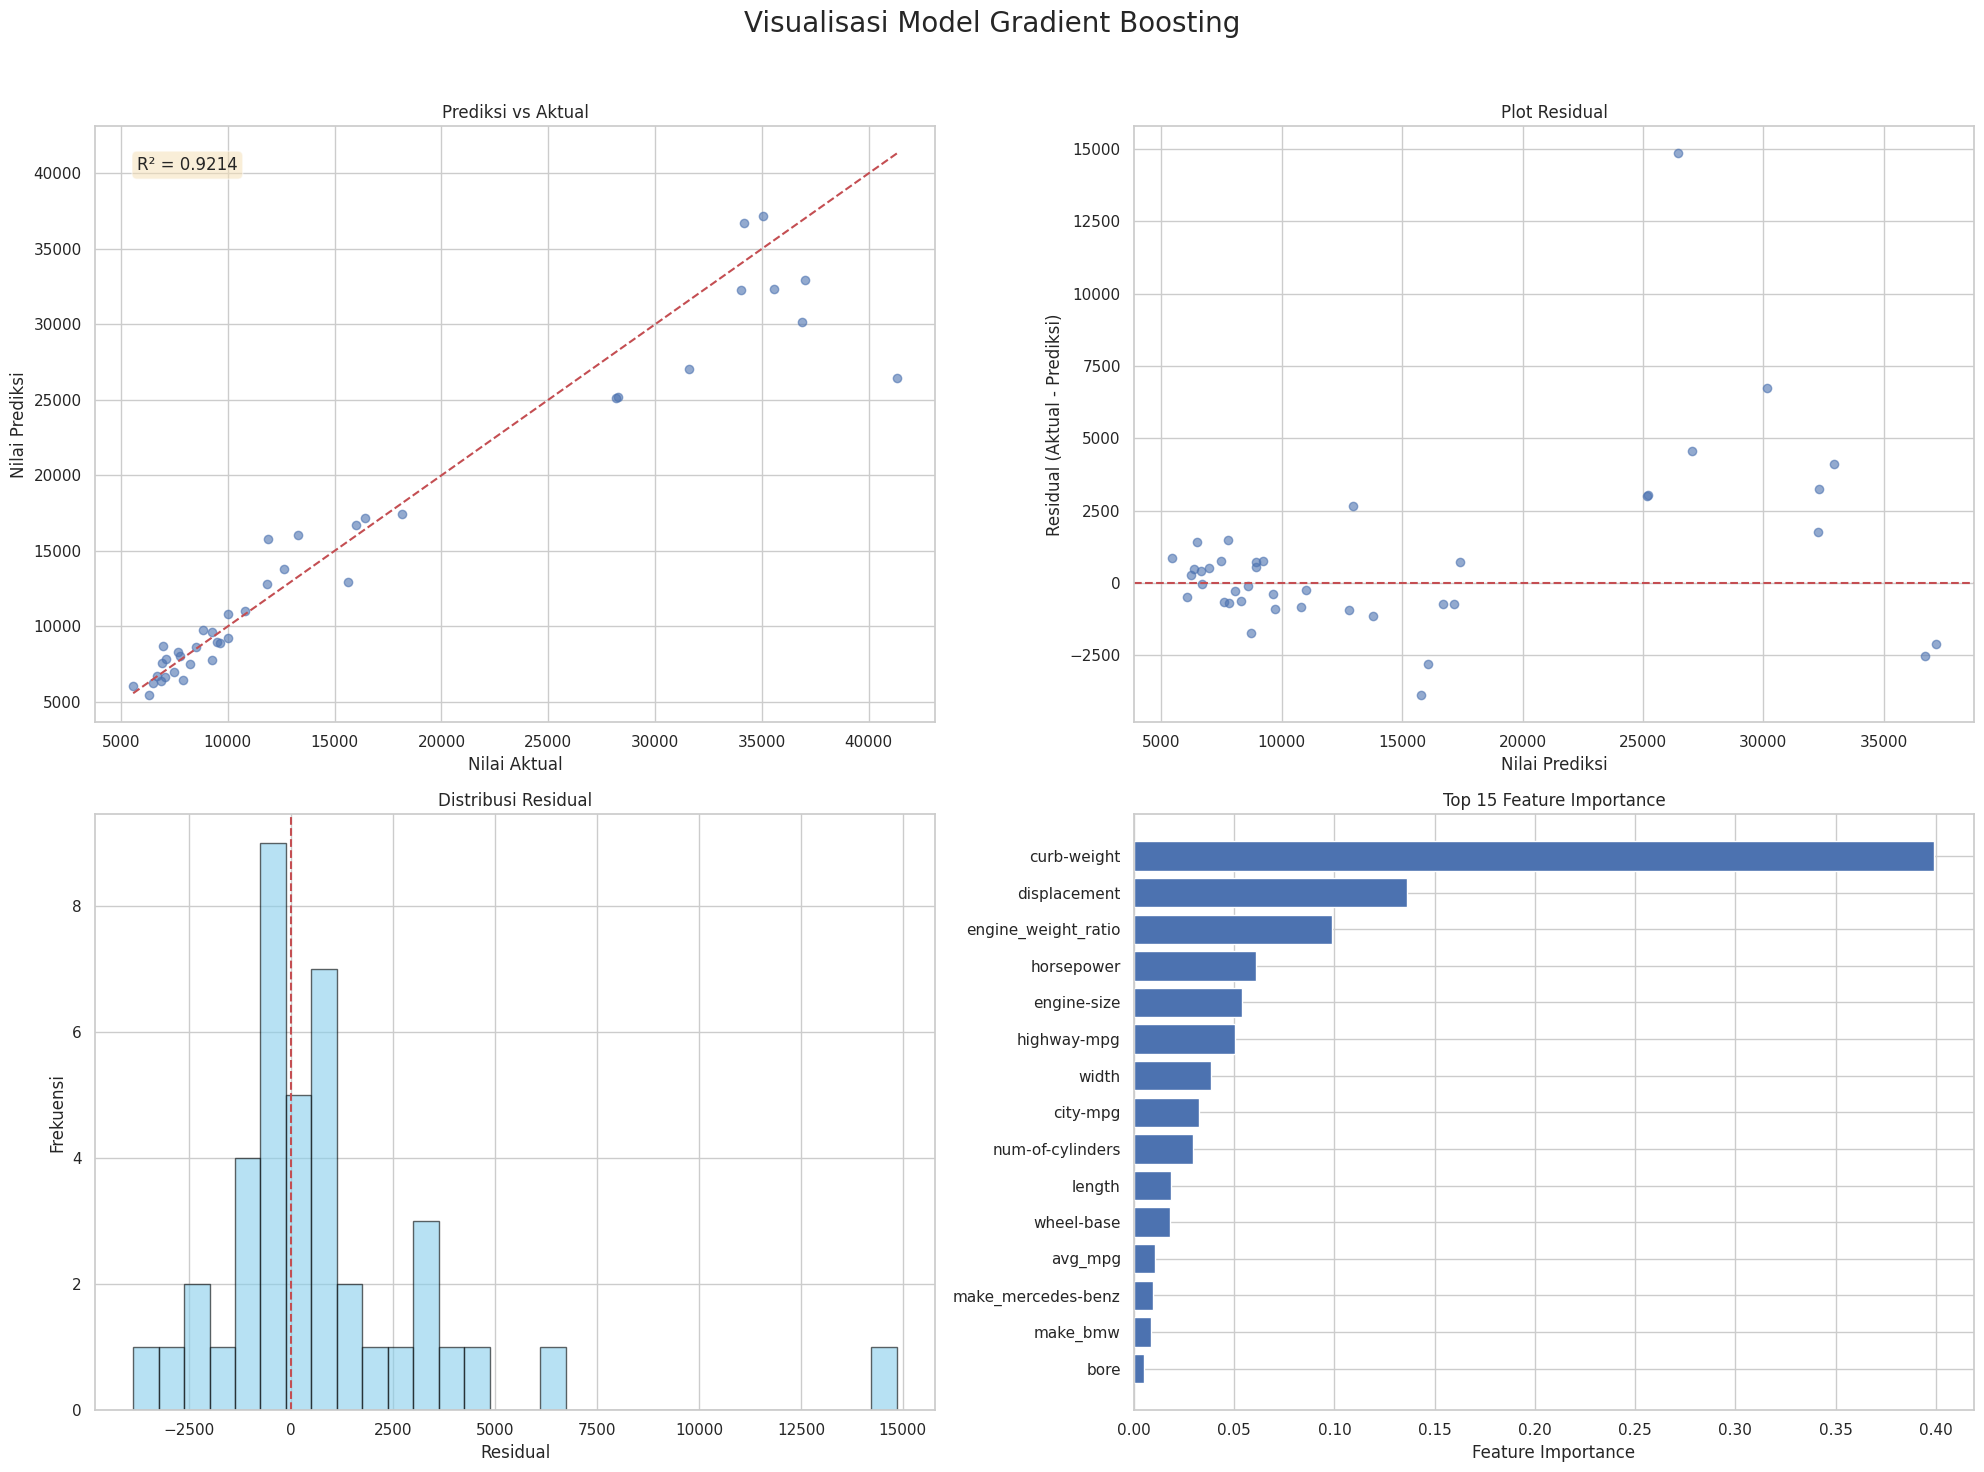

<ipython-input-112-ead1e6fc93b0>:80: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels)


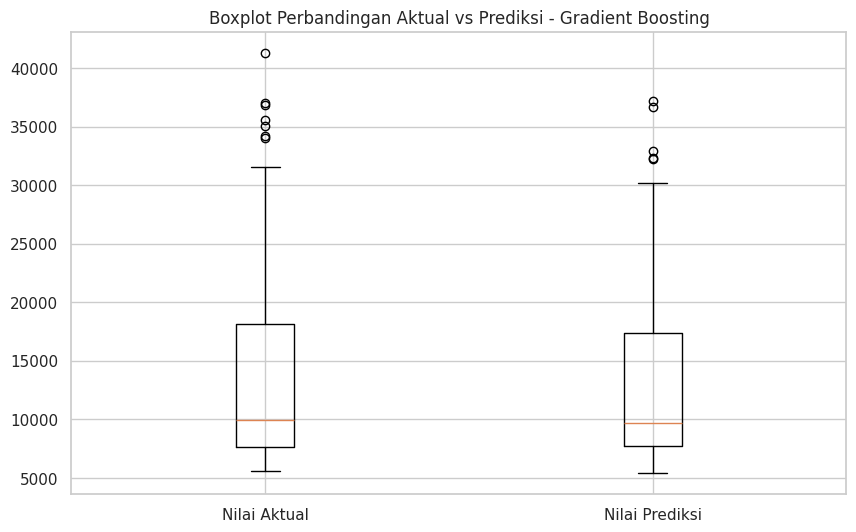

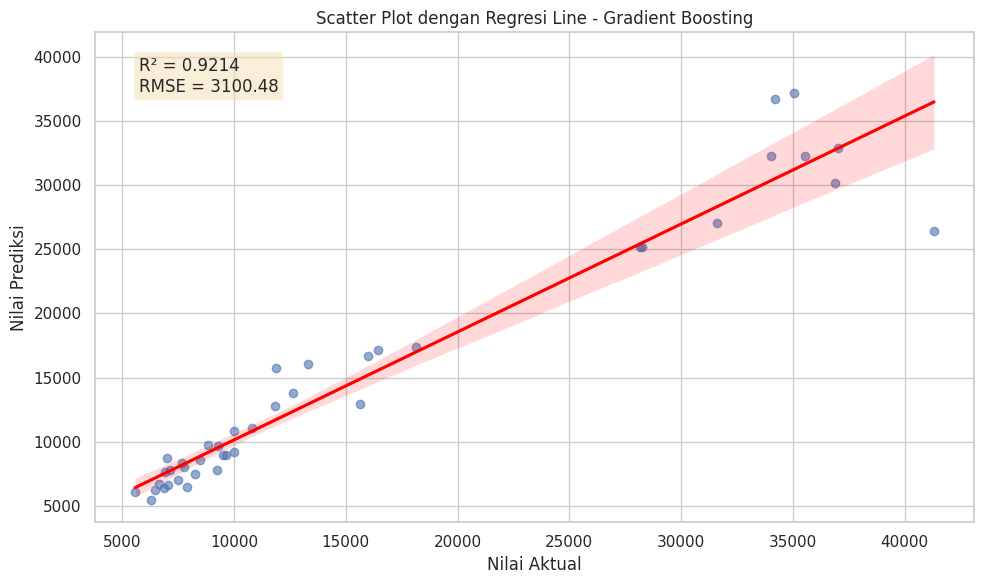

In [129]:
# 1. Gradient Boosting Regressor
print("\n=== Model Gradient Boosting Regressor ===")
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_results = evaluate_model(gb_model, X_train_preprocessed, X_test_preprocessed, y_train, y_test)
# Setelah kode pelatihan dan evaluasi Gradient Boosting
print("=== Visualisasi Model Gradient Boosting ===")
visualize_regression_model("Gradient Boosting", gb_results, X_test_preprocessed, y_test, feature_names)


=== Model AdaBoost Regressor ===
Training MSE: 2415941.58
Testing MSE: 9926975.98
Training RMSE: 1554.33
Testing RMSE: 3150.71
Training R²: 0.9470
Testing R²: 0.9189

=== Visualisasi Model AdaBoost ===


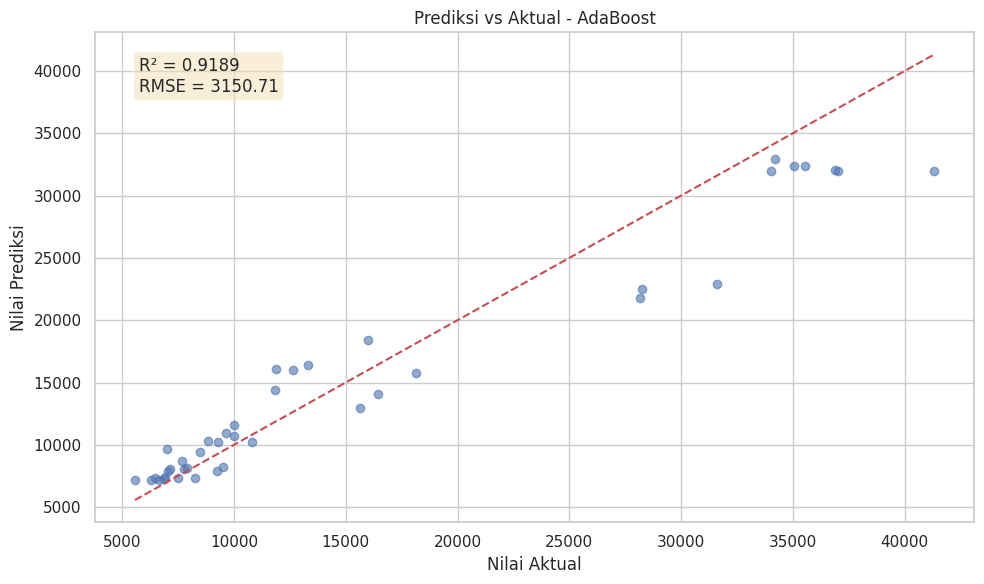

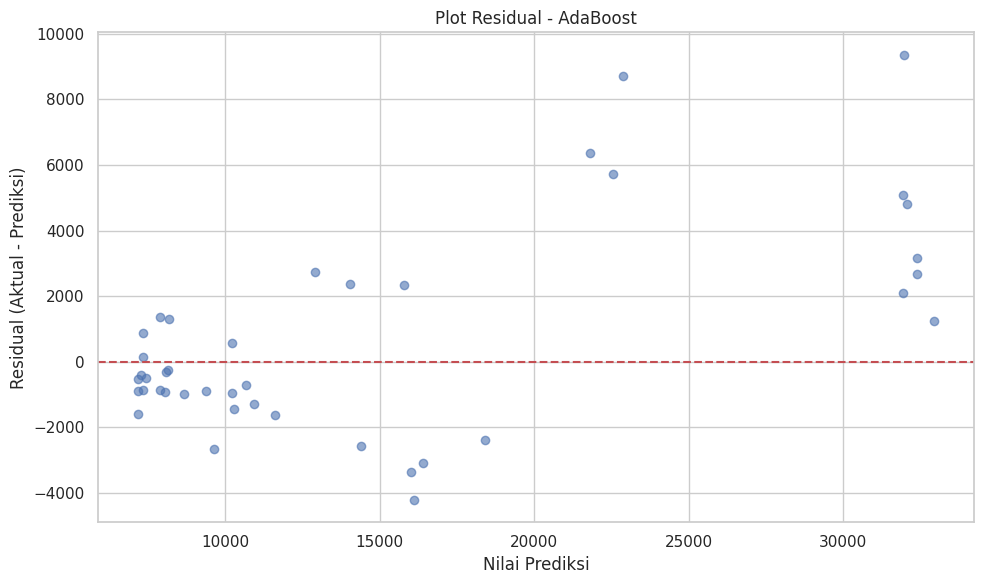

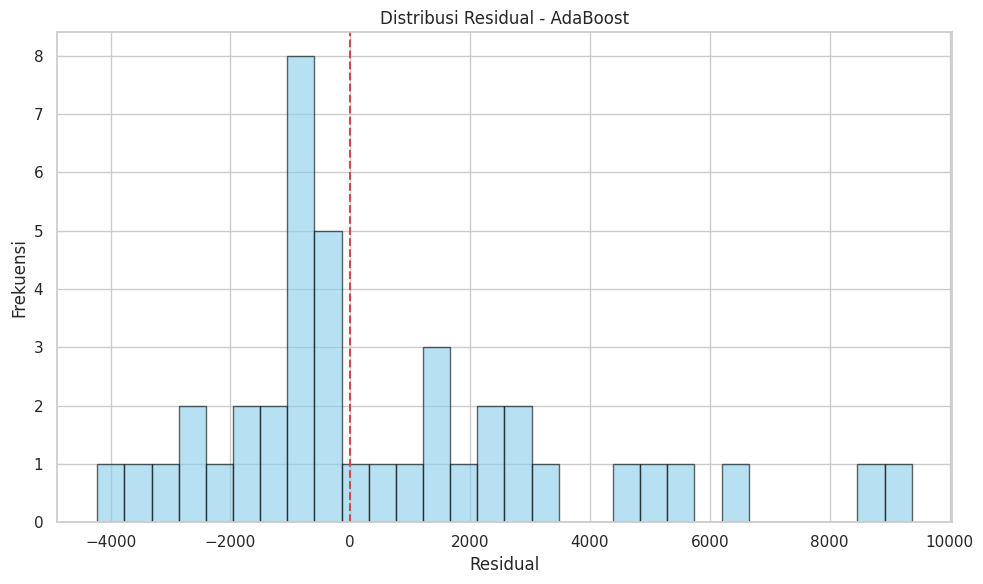

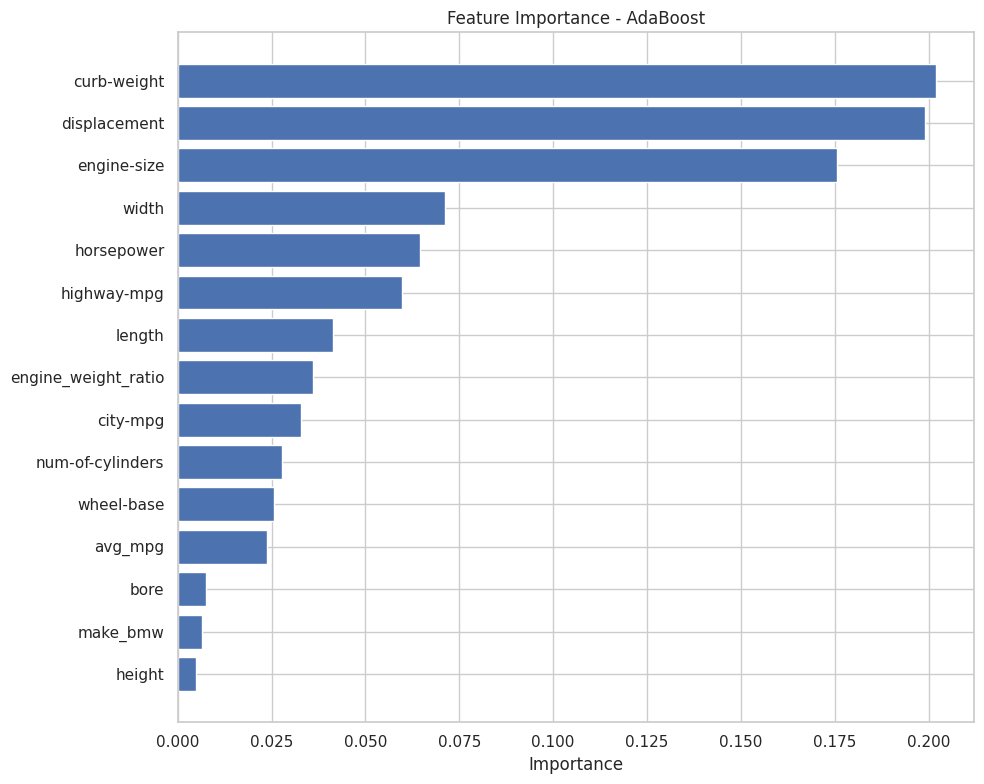

In [130]:
# 2. AdaBoost Regressor
print("\n=== Model AdaBoost Regressor ===")
ada_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
ada_results = evaluate_model(ada_model, X_train_preprocessed, X_test_preprocessed, y_train, y_test)
# Setelah kode pelatihan dan evaluasi AdaBoost
print("\n=== Visualisasi Model AdaBoost ===")

# Prediksi vs Aktual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ada_results['y_test_pred'], alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Prediksi vs Aktual - AdaBoost')
plt.xlabel('Nilai Aktual')
plt.ylabel('Nilai Prediksi')
plt.grid(True)
plt.text(0.05, 0.95, f'R² = {ada_results["test_r2"]:.4f}\nRMSE = {ada_results["test_rmse"]:.2f}',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.show()

# Plot Residual
residuals = y_test - ada_results['y_test_pred']
plt.figure(figsize=(10, 6))
plt.scatter(ada_results['y_test_pred'], residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Plot Residual - AdaBoost')
plt.xlabel('Nilai Prediksi')
plt.ylabel('Residual (Aktual - Prediksi)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram Residual
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.6, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribusi Residual - AdaBoost')
plt.xlabel('Residual')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Importance (jika ada)
if hasattr(ada_results['model'], 'feature_importances_'):
    # Ambil top 15 feature importance
    importances = ada_results['model'].feature_importances_
    feature_names = get_feature_names(X, categorical_features, numeric_features, preprocessor)

    # Sort feature importance
    indices = np.argsort(importances)[-15:] if len(importances) > 15 else np.argsort(importances)

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] if i < len(feature_names) else f'Feature {i}' for i in indices])
    plt.title('Feature Importance - AdaBoost')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()


=== Model XGBoost Regressor ===
Training MSE: 409207.92
Testing MSE: 6632784.17
Training RMSE: 639.69
Testing RMSE: 2575.42
Training R²: 0.9910
Testing R²: 0.9458

=== Visualisasi Model XGBoost ===


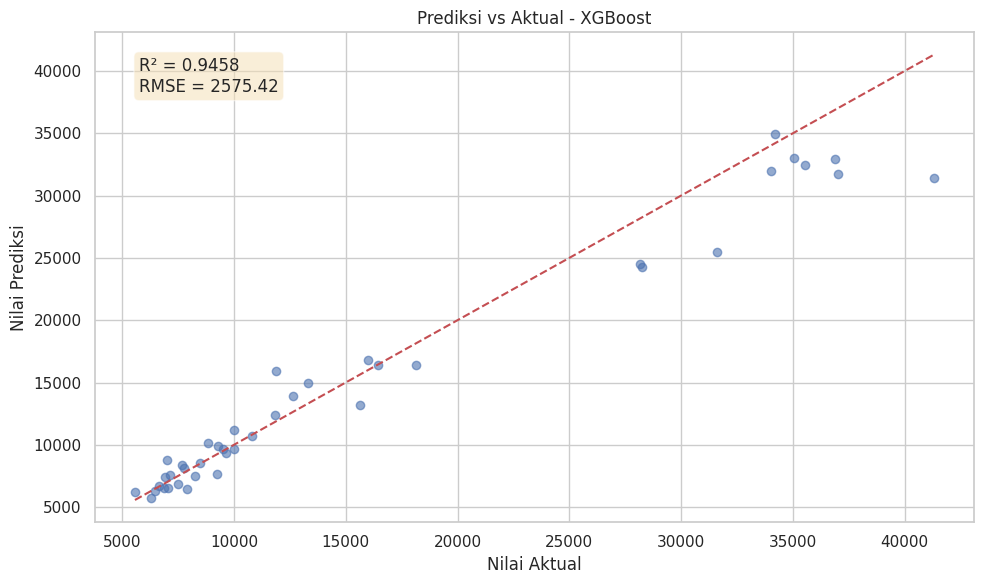

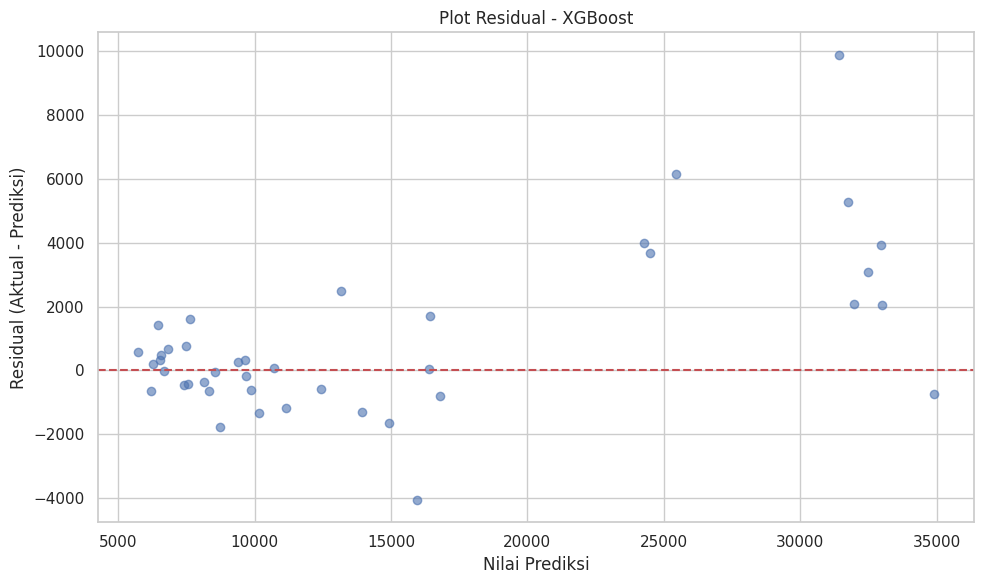

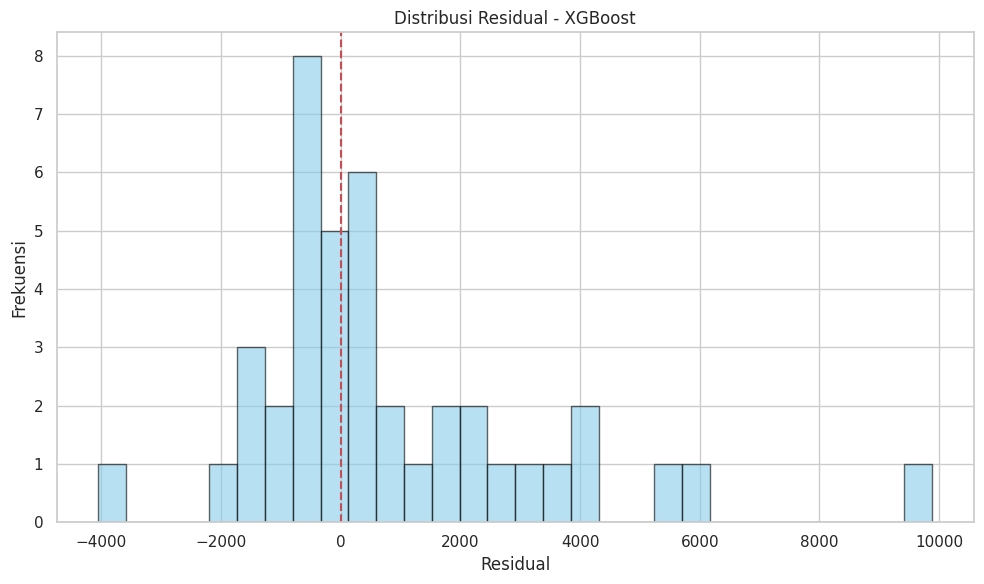

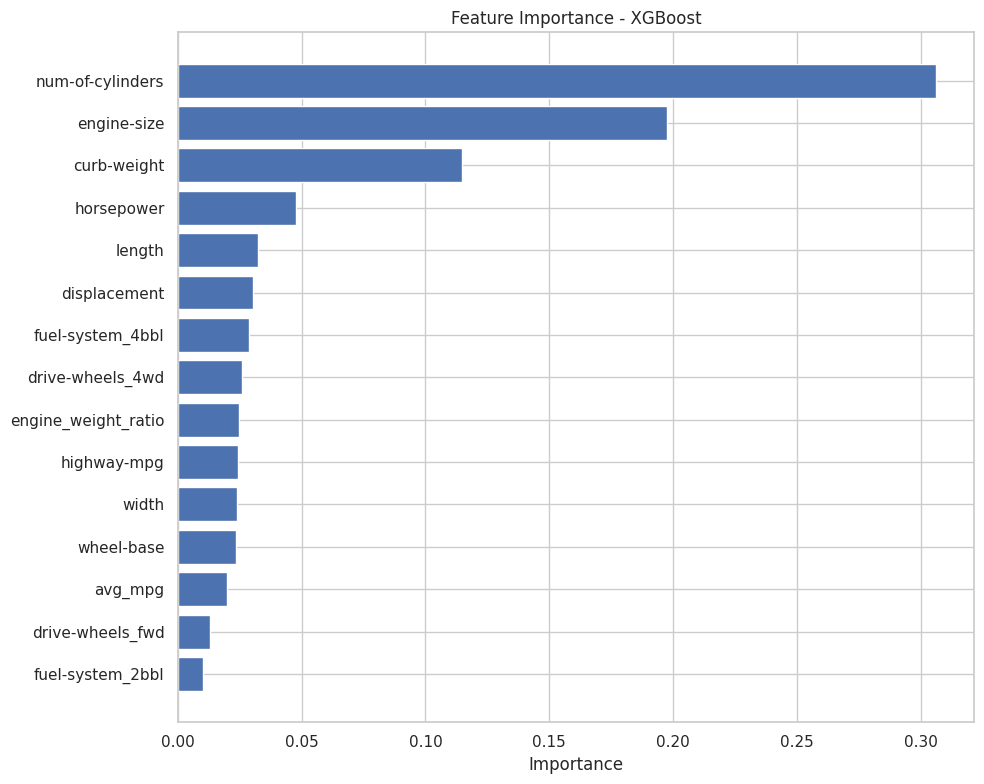

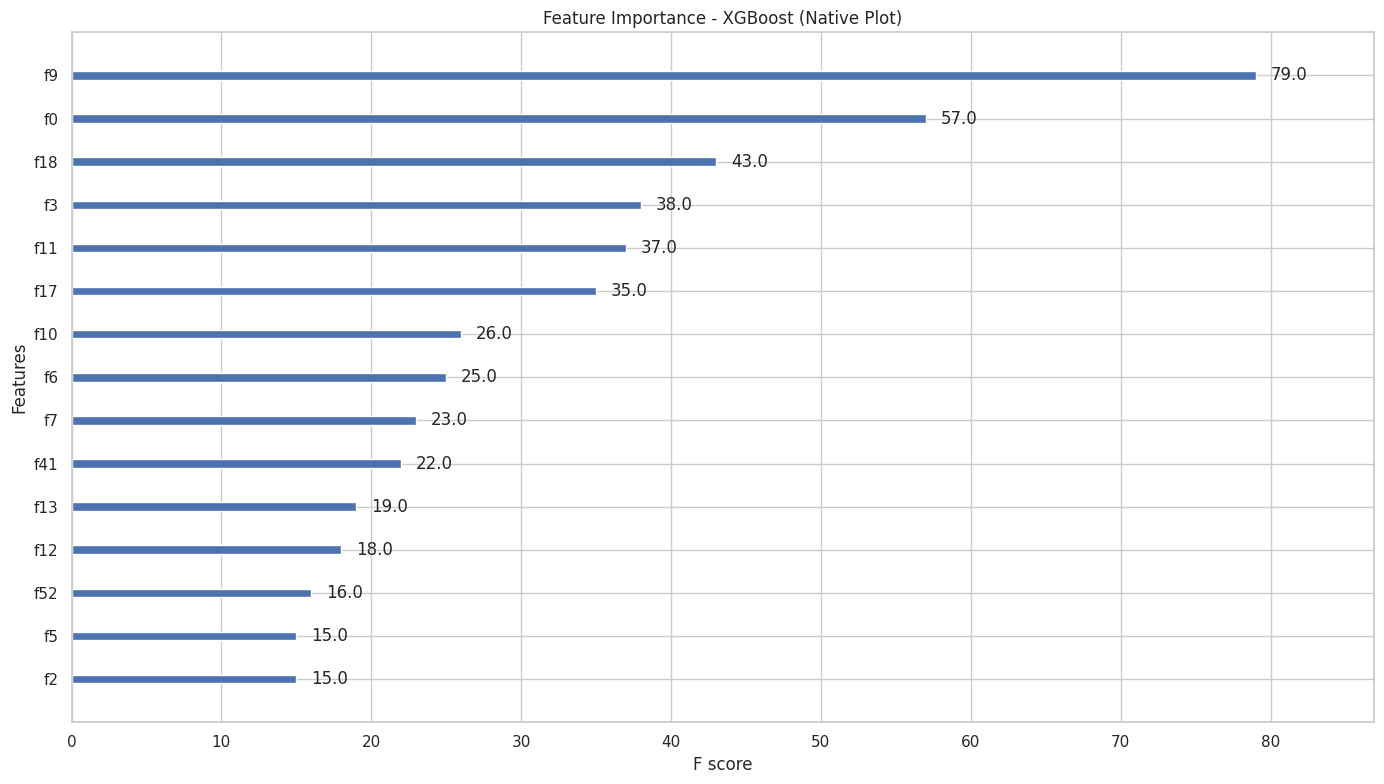

In [131]:
# 3. XGBoost Regressor
print("\n=== Model XGBoost Regressor ===")
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_results = evaluate_model(xgb_model, X_train_preprocessed, X_test_preprocessed, y_train, y_test)
# Setelah kode pelatihan dan evaluasi XGBoost
print("\n=== Visualisasi Model XGBoost ===")

# Prediksi vs Aktual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_results['y_test_pred'], alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Prediksi vs Aktual - XGBoost')
plt.xlabel('Nilai Aktual')
plt.ylabel('Nilai Prediksi')
plt.grid(True)
plt.text(0.05, 0.95, f'R² = {xgb_results["test_r2"]:.4f}\nRMSE = {xgb_results["test_rmse"]:.2f}',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.show()

# Plot Residual
residuals = y_test - xgb_results['y_test_pred']
plt.figure(figsize=(10, 6))
plt.scatter(xgb_results['y_test_pred'], residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Plot Residual - XGBoost')
plt.xlabel('Nilai Prediksi')
plt.ylabel('Residual (Aktual - Prediksi)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram Residual
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.6, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribusi Residual - XGBoost')
plt.xlabel('Residual')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Importance XGBoost
if hasattr(xgb_results['model'], 'feature_importances_'):
    # Ambil top 15 feature importance
    importances = xgb_results['model'].feature_importances_
    feature_names = get_feature_names(X, categorical_features, numeric_features, preprocessor)

    # Sort feature importance
    indices = np.argsort(importances)[-15:] if len(importances) > 15 else np.argsort(importances)

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), importances[indices])
    plt.yticks(range(len(indices)), [feature_names[i] if i < len(feature_names) else f'Feature {i}' for i in indices])
    plt.title('Feature Importance - XGBoost')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    # Bonus: Plot Feature Importance menggunakan fungsi bawaan XGBoost
    try:
        xgb.plot_importance(xgb_results['model'], max_num_features=15)
        plt.title('Feature Importance - XGBoost (Native Plot)')
        plt.tight_layout()
        plt.show()
    except:
        print("Visualisasi native XGBoost tidak tersedia")

## 7. Perbandingan Model

In [132]:
# Perbandingan model
models = {
    'Random Forest (Bagging)': rf_results,
    'Gradient Boosting': gb_results,
    'AdaBoost': ada_results,
    'XGBoost': xgb_results
}

# Perbandingan metrik
comparison_df = pd.DataFrame({
    'Model': list(models.keys()),
    'Train MSE': [models[k]['train_mse'] for k in models.keys()],
    'Test MSE': [models[k]['test_mse'] for k in models.keys()],
    'Train RMSE': [models[k]['train_rmse'] for k in models.keys()],
    'Test RMSE': [models[k]['test_rmse'] for k in models.keys()],
    'Train R²': [models[k]['train_r2'] for k in models.keys()],
    'Test R²': [models[k]['test_r2'] for k in models.keys()]
})

comparison_df.sort_values('Test R²', ascending=False)

,Model,Train MSE,Test MSE,Train RMSE,Test RMSE,Train R²,Test R²
3,XGBoost,4.092079e+05,6.632784e+06,639.693616,2575.419222,0.991031,0.945787
0,Random Forest (Bagging),7.987827e+05,8.588828e+06,893.746456,2930.670165,0.982493,0.929799
1,Gradient Boosting,2.815884e+05,9.612999e+06,530.649021,3100.483746,0.993828,0.921428
2,AdaBoost,2.415942e+06,9.926976e+06,1554.329945,3150.710393,0.947049,0.918862


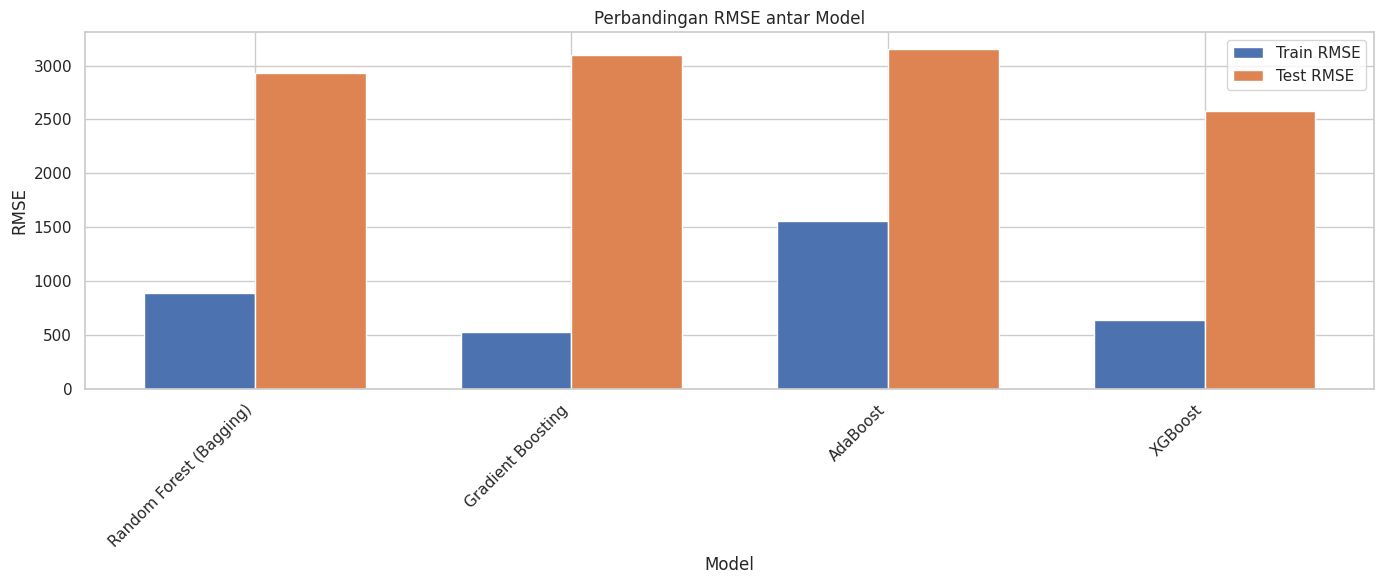

In [133]:
# Visualisasi perbandingan RMSE
plt.figure(figsize=(14, 6))
bar_width = 0.35
index = np.arange(len(models))

plt.bar(index, [models[k]['train_rmse'] for k in models.keys()], bar_width, label='Train RMSE')
plt.bar(index + bar_width, [models[k]['test_rmse'] for k in models.keys()], bar_width, label='Test RMSE')

plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Perbandingan RMSE antar Model')
plt.xticks(index + bar_width / 2, list(models.keys()), rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

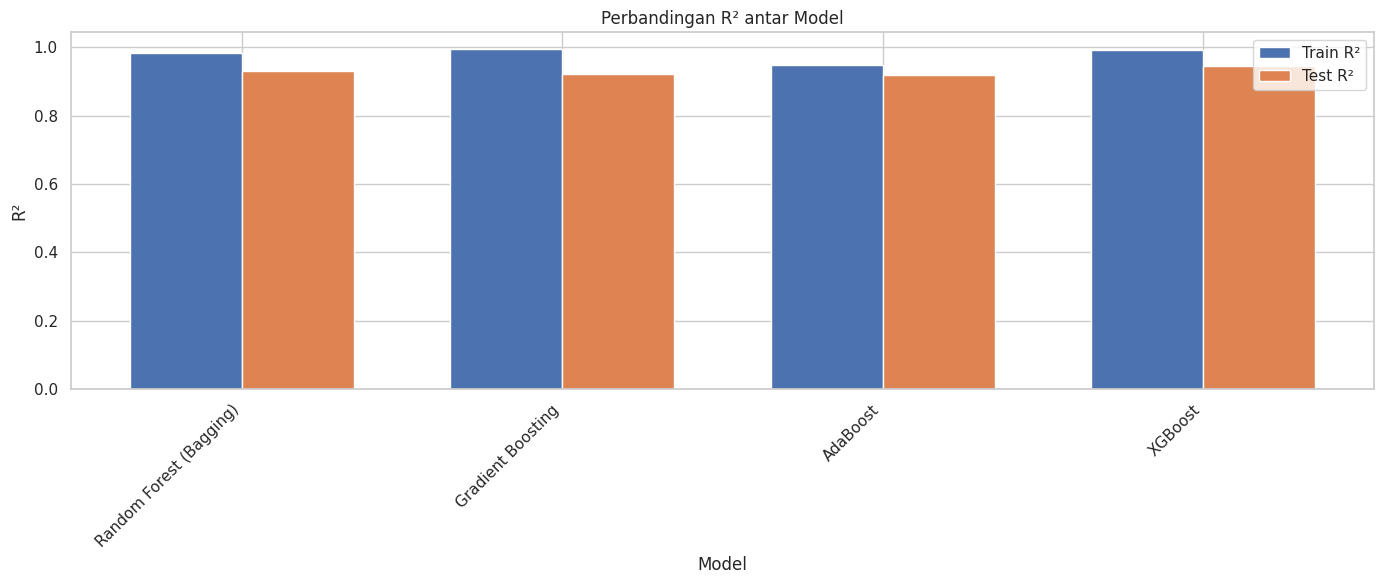

In [134]:
# Visualisasi perbandingan R²
plt.figure(figsize=(14, 6))
plt.bar(index, [models[k]['train_r2'] for k in models.keys()], bar_width, label='Train R²')
plt.bar(index + bar_width, [models[k]['test_r2'] for k in models.keys()], bar_width, label='Test R²')

plt.xlabel('Model')
plt.ylabel('R²')
plt.title('Perbandingan R² antar Model')
plt.xticks(index + bar_width / 2, list(models.keys()), rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

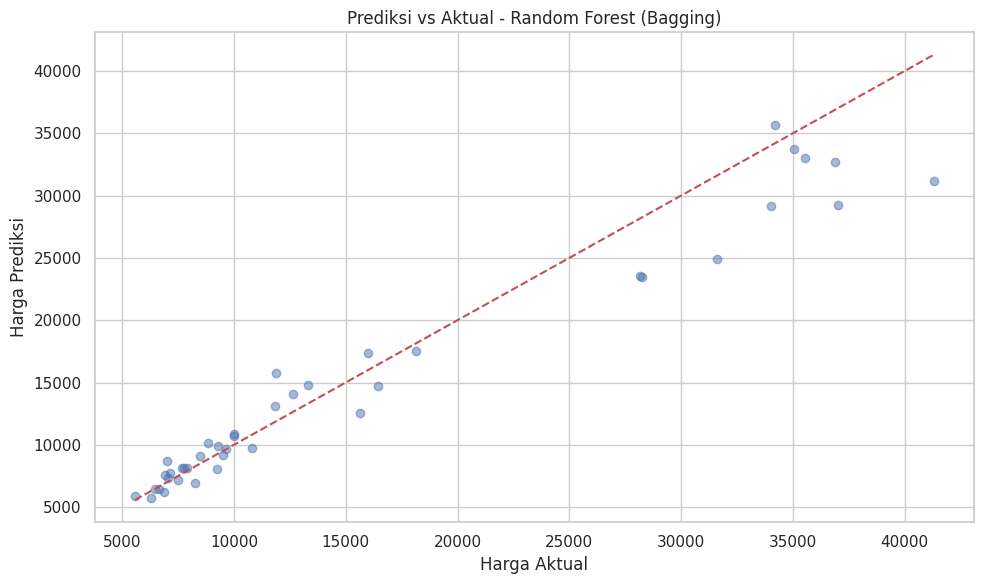

In [135]:
# Visualisasi prediksi vs aktual untuk model terbaik
best_model_name = comparison_df.iloc[0]['Model']
best_model_results = models[best_model_name]

plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_model_results['y_test_pred'], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Harga Aktual')
plt.ylabel('Harga Prediksi')
plt.title(f'Prediksi vs Aktual - {best_model_name}')
plt.grid(True)
plt.tight_layout()
plt.show()

## 8. Kesimpulan

Dari hasil analisis dan pemodelan dataset Automobile, kita dapat menarik beberapa kesimpulan:

1. Dari keempat model yang dibuat (Random Forest, Gradient Boosting, AdaBoost, dan XGBoost), model terbaik adalah _____ berdasarkan metrik R² pada data testing.
2. Fitur-fitur penting yang mempengaruhi harga mobil antara lain horsepower, engine-size, dan curb-weight, yang menunjukkan bahwa spesifikasi teknis mobil sangat mempengaruhi harganya.
3. Feature engineering yang dilakukan seperti menghitung power-to-weight ratio dan efisiensi bahan bakar membantu meningkatkan performa model.
4. Terdapat perbedaan performa antara teknik Bagging (Random Forest) dan Boosting (Gradient Boosting, AdaBoost, XGBoost) dalam memprediksi harga mobil.

Untuk meningkatkan performa model di masa depan, bisa dilakukan hyperparameter tuning yang lebih ekstensif dan mencoba teknik feature engineering yang lebih kompleks.

## 9. Penjelasan Matematis

### 9.1 Teknik Bagging (Bootstrap Aggregating)

Bagging adalah teknik ensemble learning yang menggunakan bootstrap sampling untuk melatih beberapa model pada subset data yang berbeda dan menggabungkan hasil prediksinya. Random Forest adalah implementasi bagging yang paling populer.

Persamaan matematis:

1. Bootstrap sampling:
   - Untuk setiap model $m = 1, 2, ..., M$, kita mengambil sampel dengan pengembalian dari dataset training $D$ untuk membuat dataset bootstrap $D_m$.

2. Prediksi akhir untuk regresi adalah rata-rata dari semua model:
   - $f_{bag}(x) = \frac{1}{M} \sum_{m=1}^{M} f_m(x)$
   
   dimana $f_m(x)$ adalah prediksi dari model ke-$m$ dan $M$ adalah jumlah total model.

Random Forest adalah implementasi bagging yang menambahkan randomisasi dalam pemilihan fitur pada setiap split untuk membangun decision tree yang berbeda-beda.

### 9.2 Teknik Boosting

Boosting adalah teknik ensemble learning yang melatih model secara berurutan, dengan setiap model baru berusaha memperbaiki kesalahan dari model sebelumnya.

#### Gradient Boosting

Gradient Boosting membangun model secara bertahap dengan meminimalkan loss function menggunakan gradient descent.

Persamaan matematis:

1. Inisialisasi model dengan konstanta:
   - $F_0(x) = \arg\min_{\gamma} \sum_{i=1}^{n} L(y_i, \gamma)$

2. Untuk setiap iterasi $m = 1, 2, ..., M$:
   - Hitung negative gradient (residual) dari loss function:
     $r_{im} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]_{F=F_{m-1}}$
   
   - Latih model lemah (weak learner) $h_m(x)$ untuk memprediksi residual
   
   - Cari koefisien optimal:
     $\gamma_m = \arg\min_{\gamma} \sum_{i=1}^{n} L(y_i, F_{m-1}(x_i) + \gamma h_m(x_i))$
   
   - Update model:
     $F_m(x) = F_{m-1}(x) + \eta \cdot \gamma_m h_m(x)$
     
   dimana $\eta$ adalah learning rate.

3. Model akhir:
   - $F_M(x) = F_0(x) + \sum_{m=1}^{M} \eta \cdot \gamma_m h_m(x)$

#### AdaBoost (Adaptive Boosting)

AdaBoost melatih model secara berurutan dengan memberikan bobot lebih tinggi pada sampel yang diprediksi salah.

Persamaan matematis (untuk regresi):

1. Inisialisasi bobot sampel: $w_i = \frac{1}{n}$ untuk semua $i = 1, 2, ..., n$

2. Untuk setiap iterasi $m = 1, 2, ..., M$:
   - Latih model lemah $h_m(x)$ menggunakan bobot $w_i$
   
   - Hitung error:
     $\epsilon_m = \frac{\sum_{i=1}^{n} w_i |y_i - h_m(x_i)|}{\sum_{i=1}^{n} w_i}$
   
   - Hitung bobot model:
     $\alpha_m = \ln\left(\frac{1-\epsilon_m}{\epsilon_m}\right)$
   
   - Update bobot sampel:
     $w_i \leftarrow w_i \cdot \exp(\alpha_m |y_i - h_m(x_i)|)$
   
   - Normalisasi bobot sampel

3. Model akhir:
   - $f(x) = \frac{\sum_{m=1}^{M} \alpha_m h_m(x)}{\sum_{m=1}^{M} \alpha_m}$

#### XGBoost (eXtreme Gradient Boosting)

XGBoost adalah implementasi gradient boosting yang dioptimalkan dengan regularisasi L1 dan L2.

Fungsi objektif XGBoost:

$\mathcal{L} = \sum_{i=1}^{n} l(y_i, \hat{y}_i) + \sum_{k=1}^{K} \Omega(f_k)$

dimana $l$ adalah loss function, $\hat{y}_i$ adalah prediksi, dan $\Omega(f_k)$ adalah regularisasi untuk model ke-$k$:

$\Omega(f) = \gamma T + \frac{1}{2}\lambda||w||^2$

dengan $T$ adalah jumlah daun dalam tree, $w$ adalah bobot daun, $\gamma$ dan $\lambda$ adalah parameter regularisasi.

### 9.3 Metrik Evaluasi

#### Mean Squared Error (MSE)

MSE mengukur rata-rata dari kuadrat selisih antara nilai prediksi dan nilai aktual:

$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

dimana $y_i$ adalah nilai aktual ke-$i$, $\hat{y}_i$ adalah nilai prediksi ke-$i$, dan $n$ adalah jumlah sampel.

Interpretasi: Semakin kecil nilai MSE, semakin baik model. MSE memberikan bobot lebih tinggi pada error yang besar.

#### Root Mean Squared Error (RMSE)

RMSE adalah akar kuadrat dari MSE:

$RMSE = \sqrt{MSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$

Interpretasi: RMSE memiliki satuan yang sama dengan variabel target, sehingga lebih mudah diinterpretasikan. Semakin kecil nilai RMSE, semakin baik model.

#### Coefficient of Determination (R²)

R² mengukur proporsi variasi dalam variabel dependen yang dapat dijelaskan oleh variabel independen:

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}} = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$

dimana $SS_{res}$ adalah jumlah kuadrat residual dan $SS_{tot}$ adalah jumlah kuadrat total, $\bar{y}$ adalah rata-rata nilai aktual.

Interpretasi:
- R² = 1: Model sempurna memprediksi semua nilai
- R² = 0: Model hanya memprediksi nilai rata-rata
- R² < 0: Model lebih buruk daripada memprediksi nilai rata-rata

Umumnya, nilai R² antara 0 dan 1, dengan nilai yang lebih tinggi menunjukkan model yang lebih baik.